# Closed system simulation with experimental data markers

In this simulation we have a system of 5 liters in which we start with Next = 1000, some Nint (measured) of some mass (m). After this we "feed" for a period of 3.5 days, i.e. solve the "feeding" part of the simulation. After that, we add 1000 uM to the last value of Next and keep "feeding". After one duration (7 days) we reset the water, mass and the amplitude to the beginning of the first cycle. The only difference from the t_0 is the Nint which is accumulating all the effects through the time. The mass is reset to m_0 and Next is reset to 1000 ppm (per something per something)


In [1]:
# N_simulation
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd # to read excel
from pandas import DataFrame
from statistics import mean, stdev
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

from myfunctions import *


# from datetime import datetime

In [2]:
xl = pd.ExcelFile('../data/input_format.xlsx')

df1 = xl.parse('Parameters',header=None)
df2 = xl.parse('500.3.5.168')#header=None)


# which parameters? and values we read? if you want to print, uncomment:
# print(df.iloc[:][0],df.iloc[:][1])

# assigmment of parameters to values: 
for key,val in zip(df1.iloc[:][0],df1.iloc[:][1]):
    exec(key + '=val')
    print(key,val)

dNextoutdt 0.03
dNextindt 0.0
dmoutdt 0.0
miu 0.014583333333333332
Nintmax 4.23
Nintmin 1.0
NH4max 100.0
NH4min 0.0
KNH4 10.0
KN 2.0
Ks 14.0
Vmax 60.0
Vassim 60.0
Next0 0.0
NH40 0.0
Nint0 1.85
m0 0.15
Amplitude 500.0
Duration 7.0
Period 3.5
Kd 0.4
Nintcrit 3.0


In [3]:
# find out how many experiments are in the file
n_exp = df2['day i'].dropna().shape[0] # number of items that have day i property and not NaN

# it should be equal to the number of day f - just for a test. will pop an error if the file is corrupted
assert (n_exp == df2['day f'].dropna().shape[0])

print('N of experiments = {}'.format(n_exp))

N of experiments = 15


In [4]:
day_i = df2['day i'].dropna()
day_i.astype('S')

0     b'22.07.19'
7     b'22.07.19'
14    b'22.07.19'
21    b'22.07.19'
28    b'22.07.19'
35    b'22.07.19'
42    b'22.07.19'
49    b'22.07.19'
56    b'22.07.19'
62    b'06.05.19'
68    b'06.05.19'
74    b'06.05.19'
80    b'03.10.19'
86    b'03.10.19'
92    b'03.10.19'
Name: day i, dtype: bytes64

In [5]:
# find out the sleeve number in each experiment
sleeves = df2['sleeve'].dropna().astype(int)
for s in sleeves:
    print('sleeve {}'.format(s))

sleeve 1
sleeve 2
sleeve 3
sleeve 4
sleeve 5
sleeve 6
sleeve 7
sleeve 8
sleeve 9
sleeve 7
sleeve 8
sleeve 9
sleeve 4
sleeve 5
sleeve 6


In [6]:
ind_Nint = df2.index[df2['parameter'] == 'Nint'] # find index of the Nint rows
print(ind_Nint) # print it for the reference, these are rows 2, 6 and 10

# small test
assert(len(ind_Nint) == n_exp) # if we found less Nint than experiments, then something is wrong


df2.iloc[ind_Nint[1],4:].dropna() # take the 2nd element of that index, i.e. 2nd experiment and show the data:

Int64Index([3, 10, 17, 24, 31, 38, 45, 52, 59, 65, 71, 77, 83, 89, 95], dtype='int64')


Unnamed: 4      1.5702
Unnamed: 5     2.93388
Unnamed: 6        2.05
Unnamed: 7     2.50798
Unnamed: 8     2.25557
Unnamed: 9     3.00527
Unnamed: 10    2.45769
Name: 10, dtype: object

In [7]:
ind_Next = df2.index[df2['parameter'] == 'Next'] # find index of the Next 
Next_measurement_times = pd.to_datetime(df2.iloc[ind_Next[0]-1,4:].dropna(),dayfirst=True)
print(Next_measurement_times)

Unnamed: 4    2019-07-22 15:00:00
Unnamed: 5    2019-07-25 10:00:00
Unnamed: 6    2019-07-29 20:30:00
Unnamed: 7    2019-08-01 12:45:00
Unnamed: 8    2019-08-05 16:15:00
Unnamed: 9    2019-08-06 12:00:00
Unnamed: 10   2019-08-07 09:00:00
Unnamed: 11   2019-08-08 10:00:00
Unnamed: 12   2019-08-11 09:00:00
Unnamed: 13   2019-08-12 13:00:00
Name: 0, dtype: datetime64[ns]


In [8]:
# plot all sleeves m data
ind_m = df2.index[df2['parameter'] == 'm'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_m) == n_exp) # if we found less Nint than experiments, then something is wrong


# fig,ax = plt.subplots(figsize=(12,10))

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('mass');

m_all, m_times_all, Nint_all, Nint_times_all, Next_all, Next_times_all = [], [], [], [], [], []

for counter,value in enumerate(ind_m):
    m = df2.iloc[value,4:]
    val = []
    for number in m:
        a=~np.isnan(number)
        val.append(a)
    m = df2.iloc[value,4:][val] #'value' gives row number, '4:' goes column by column starting at 4.
    m_measurement_times = pd.to_datetime(df2.iloc[value-1,4:][val],dayfirst=True)
    hours = pd.Series((m_measurement_times - m_measurement_times[0]).astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    print(counter, label)
 #   ax.plot(hours,m,':o',label=label,lw=2)
    
    for sample in m:
        m_all.append(sample)
    
    for h in hours:
        m_times_all.append(h)
        

m_times_all = np.array(m_times_all, dtype='int')
        
# ax.legend()
# ax.set_xlabel('Time (hours)')
# ax.set_ylabel('mass (g DW / l)');

0 22.07.19 sleeve1
1 22.07.19 sleeve2
2 22.07.19 sleeve3
3 22.07.19 sleeve4
4 22.07.19 sleeve5
5 22.07.19 sleeve6
6 22.07.19 sleeve7
7 22.07.19 sleeve8
8 22.07.19 sleeve9
9 06.05.19 sleeve7
10 06.05.19 sleeve8
11 06.05.19 sleeve9
12 03.10.19 sleeve4
13 03.10.19 sleeve5
14 03.10.19 sleeve6


In [9]:
# plot all sleeves Nint data
ind_Nint = df2.index[df2['parameter'] == 'Nint'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_Nint) == n_exp) # if we found less Nint than experiments, then something is wrong

# fig,ax = plt.subplots(figsize=(12,10))

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Nint');

Nint_all, Nint_times_all = [], []
for counter,value in enumerate(ind_Nint):
    Nint = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Nint:
        a=~np.isnan(number)
        val.append(a)
    Nint = df2.iloc[value,4:][val]
    Nint_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Nint_measurement_times - Nint_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
#    ax.plot(hours,Nint,':o',label=label,lw=2)
    
    for sample in Nint:
        Nint_all.append(sample)
    
    for h in hours:
        Nint_times_all.append(h)


Nint_times_all = np.array(Nint_times_all, dtype='int')
        
# ax.legend()
# ax.set_xlabel('Time (hours)')
# ax.set_ylabel('Nint (% g N / g DW)');

In [10]:
# plot all sleeves Next data
ind_Next = df2.index[df2['parameter'] == 'Next'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_Next) == n_exp) # if we found less Nint than experiments, then something is wrong

#fig,ax = plt.subplots(figsize=(12,10))

#plt.legend()
#plt.xlabel('Time')
#plt.ylabel('Next');

Next_all, Next_times_all = [], []
for counter,value in enumerate(ind_Next):
    Next = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Next:
        a=~np.isnan(number)
        val.append(a)
    Next = df2.iloc[value,4:][val]
    Next_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Next_measurement_times - Next_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
#    ax.plot(hours,Next,':o',label=label,lw=2)
    
    for sample in Next:
        Next_all.append(sample)
    
    for h in hours:
        Next_times_all.append(h)

Next_times_all = np.array(Next_times_all, dtype='int')
#ax.legend()
#ax.set_xlabel('Time (hours)')
#ax.set_ylabel('Next (umol N / l)');

In [11]:
# Create time array of 500 hours, integer types, used for data interpolation (t_hours)

t_hours = np.linspace(0,499,500)
t_hours = np.array(t_hours, dtype='int')

In [12]:
# Reduce Nint measurements into 4 arrays: 1. Measurement times (Nint_times_reduced); 2. Mean values (Nint_mean_values); 
# 3. STDEV values (Nint_stdev_values); and 4. Number of measurements per time (N_Nint_values)

Nint_times_all, Nint_all = zip(*sorted(zip(Nint_times_all, Nint_all)))
Nint_values, Nint_times_reduced, Nint_mean_values, Nint_stdev_values,N_Nint_values = [], [], [], [], []
i = 0
for TNint in Nint_times_all:
    TNint = int(TNint)
    Nint_values.append(Nint_all[i])
    Mean_Nint = mean(Nint_values)
    N_Nint = len(Nint_values)
    if len(Nint_values) >= 2:
        STDEV_Nint = stdev(Nint_values)
    else:
        STDEV_Nint = 0
    if  i == len(Nint_times_all)-1 or Nint_times_all[i] != Nint_times_all[i + 1]:
        Nint_times_reduced.append(TNint)
        Nint_values = []
        Nint_mean_values.append(Mean_Nint)
        Nint_stdev_values.append(STDEV_Nint)
        N_Nint_values.append(N_Nint)
    i += 1

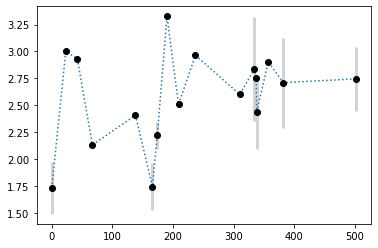

In [13]:
# Interpolate Nint data (Nint_interp)

f1 = interpolate.interp1d(Nint_times_reduced, Nint_mean_values,kind = 'linear')
Nint_interp = f1(t_hours)
plt.plot(t_hours, Nint_interp, ':')
plt.errorbar(Nint_times_reduced,Nint_mean_values,yerr=Nint_stdev_values,fmt='o',color='black',ecolor='lightgray',elinewidth=3,capsize=0)
plt.plot()

N_Nint_values = list(map(str, N_Nint_values))

In [14]:
# Reduce Next measurements into 4 arrays: 1. Measurement times (Next_times_reduced); 2. Mean values (Next_mean_values); 
# 3. STDEV values (Next_stdev_values); and 4. Number of measurements per time (N_Next_values)

Next_times_all, Next_all = zip(*sorted(zip(Next_times_all, Next_all)))
Next_values, Next_times_reduced, Next_mean_values, Next_stdev_values,N_Next_values = [], [], [], [], []
i = 0
for TNext in Next_times_all:
    TNext = int(TNext)
    Next_values.append(Next_all[i])
    Mean_Next = mean(Next_values)
    N_Next = len(Next_values)
    if len(Next_values) >= 2:
        STDEV_Next = stdev(Next_values)
    else:
        STDEV_Next = 0
    if  i == len(Next_times_all)-1 or Next_times_all[i] != Next_times_all[i + 1]:
        Next_times_reduced.append(TNext)
        Next_values = []
        Next_mean_values.append(Mean_Next)
        Next_stdev_values.append(STDEV_Next)
        N_Next_values.append(N_Next)
    i += 1

[]

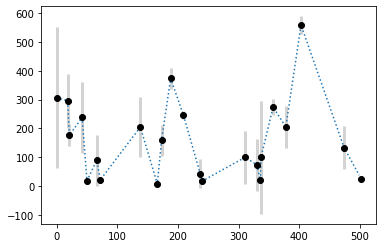

In [15]:
# Interpolate Nint data (Next_interp)

f2 = interpolate.interp1d(Next_times_reduced, Next_mean_values,kind = 'linear')
Next_interp = f2(t_hours)
plt.plot(t_hours, Next_interp, ':')
plt.errorbar(Next_times_reduced,Next_mean_values,yerr=Next_stdev_values,fmt='o',color='black',ecolor='lightgray',elinewidth=3,capsize=0)
plt.plot()

In [16]:
# Reduce m measurements into 4 arrays: 1. Measurement times (m_times_reduced); 2. Mean values (m_mean_values); 
# 3. STDEV values (m_stdev_values); and 4. Number of measurements per time (N_m_values)

m_times_all, m_all = zip(*sorted(zip(m_times_all, m_all)))
m_values, m_times_reduced, m_mean_values, m_stdev_values,N_m_values = [], [], [], [], []
i = 0
for Tm in m_times_all:
    Tm = int(Tm)
    m_values.append(m_all[i])
    Mean_m = mean(m_values)
    N_m = len(m_values)
    if len(m_values) >= 2:
        STDEV_m = stdev(m_values)
    else:
        STDEV_m = 0
    if  i == len(m_times_all)-1 or m_times_all[i] != m_times_all[i + 1]:
        m_times_reduced.append(Tm)
        m_values = []
        m_mean_values.append(Mean_m)
        m_stdev_values.append(STDEV_m)
        N_m_values.append(N_m)
    i += 1


[]

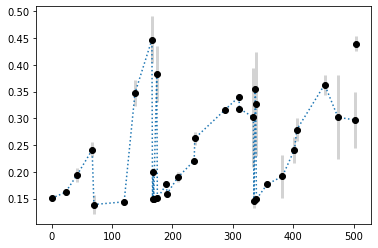

In [17]:
# Interpolate Nint data (m_interp)

f3 = interpolate.interp1d(m_times_reduced, m_mean_values,kind = 'linear')
m_interp = f3(t_hours)
plt.plot(t_hours, m_interp, ':')
plt.errorbar(m_times_reduced,m_mean_values,yerr=m_stdev_values,fmt='o',color='black',ecolor='lightgray',elinewidth=3,capsize=0)
plt.plot()

In [18]:
t_hours2 = np.linspace(0,504,505)
t_hours2 = np.array(t_hours2, dtype='int')

In [19]:
# now combine the two:
# decide how many cycles you want, e.g. 10 days, with a daily feeding
NEXT, NINT, M, T = [],[],[],[]
NINT = [] #[[Nint0]]
#bbb = NINT[-1]
#print (bbb)
Period_times = [0]
Duration_times = [0]
n_days = Duration*3


for hour in np.arange(0,n_days*24,Period*24):
    hour = int(hour)
    print(hour)
    
    if hour == 0:
        print('Starting point')
        Nint_0 = Nint0
        m_0 = m0
        Next_0 = Amplitude
    
    if hour > 0 and np.mod(hour,Period*24) == 0:
        if np.mod(hour,Duration*24) == 0:
            print('Duration')
            # reset everything, except Nint
            Nint_0 = NINT[-1][-1]
            Next_0 = Amplitude
            m_0 = m0
            Period_times.append(hour)# + 10)
            Duration_times.append(hour)# + 10)
            
        else:    
            # period passed, not Duration
            # add amplitude, keep going 
            print('Period')
            Next_0 = NEXT[-1][-1] + Amplitude
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]
            Period_times.append(hour)# + 10)

        
    # setup initial conditions
    x0 = [Next_0,Nint_0,m_0]
    #t = np.linspace(hour,hour+Period*24)
    #t = t_hours[hour:int(Period*24+hour)]
    t = t_hours2[hour:int(Period*24+hour)]
    #print(t)
    x = odeint(N_feeding,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,KN,dNextoutdt,dNextindt,miu,dmoutdt))

    NEXT.append(x[: , 0])
    NINT.append(x[: , 1])
    M.append(x[: , 2])
    T.append(t)
    
    t_model = np.hstack(T)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)

Period_times.append(Duration*3*24)# + 10)
Duration_times.append(Duration*3*24)#+10)
Period_times = np.array(Period_times, dtype='int')
Duration_times = np.array(Duration_times, dtype='int')
print(Period_times)
print(Duration_times)

0
Starting point
84
Period
168
Duration
252
Period
336
Duration
420
Period
[  0  84 168 252 336 420 504]
[  0 168 336 504]


# Read the experimental data from the same file, second sheet

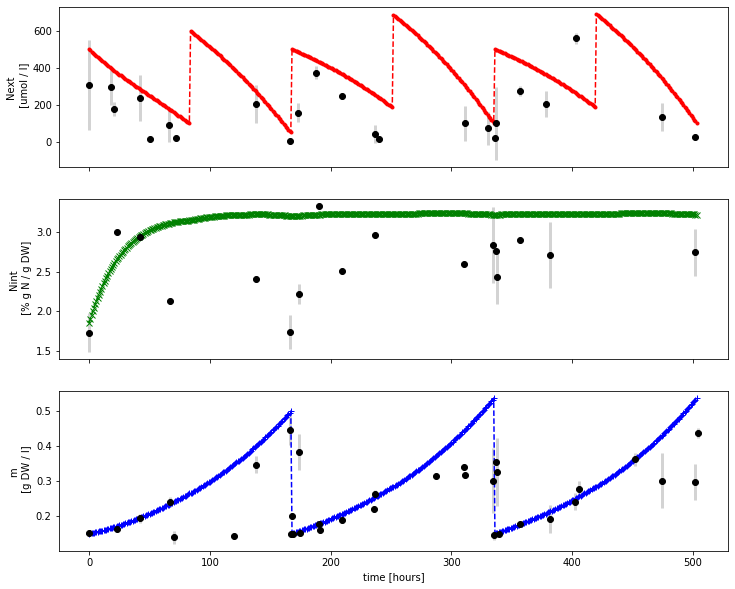

In [20]:
plot_result(t_model,Next_model,Nint_model,m_model,Nint=Nint_mean_values, yerrNint=Nint_stdev_values ,tNint=Nint_times_reduced,m=m_mean_values, yerrm=m_stdev_values, tm=m_times_reduced,Next=Next_mean_values,yerrNext=Next_stdev_values, tNext=Next_times_reduced)

In [21]:
len(t_model)

504

In [22]:
# TRE = (100/n) * sqrt (sigma[1:m]((PVi-Si)/Si)^2)

# where n is the number of measurements, Si is the measured values,and PVi is the predicted value

#TRE m

Sim, PVim, squere_error_m, trem = [], [], [], []
nmt = len(m_times_all)
nm = len(m_all)

m_times_all_tup = np.array(m_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

m_all_ind = np.linspace(0,nmt - 1,nmt)
m_all_ind = np.array(m_all_ind, dtype='int')

for i in m_all_ind:
    if i < 1 or m_times_all_tup[i] != m_times_all_tup[i-1]:
        j = m_times_all_tup[i]
        while j >= len(m_model):
            #m_model.append(m_model[-1])
            m_model = np.append(m_model, m_model[-1])
            #print(len(m_model))
    PVim.append(m_model[j])
    Sim.append(m_all[i])
    squere_error_m = ((PVim[-1] - Sim[-1]) / Sim[-1]) ** 2
    #if squere_error_m.size > 0:
    #trem.append(squere_error_m)
    trem.append(((PVim[-1] - Sim[-1]) / Sim[-1]) ** 2)
    #print(j,i)
    #print(PVim[-1])
    #print(Sim[-1])
    #print(squere_error_m, '\n')

TREm = round((100/nm * (sum(trem) ** 0.5)),1)

#TRE Nint

SiNint, PViNint, squere_error_Nint, treNint = [], [], [], []

nNintt = len(Nint_times_all)
nNint = len(Nint_all)

Nint_times_all_tup = np.array(Nint_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

Nint_all_ind = np.linspace(0,nNintt - 1,nNintt)
Nint_all_ind = np.array(Nint_all_ind, dtype='int')

for i in Nint_all_ind:
    if i < 1 or Nint_times_all_tup[i] != Nint_times_all_tup[i-1]:
        j = Nint_times_all_tup[i]
        while j >= len(Nint_model):
            #Nint_model.append(Nint_model[-1])
            Nint_model = np.append(Nint_model,Nint_model[-1])
            #print(len(Nint_model))
    PViNint.append(Nint_model[j])
    SiNint.append(Nint_all[i])
    squere_error_Nint = ((PViNint[-1] - SiNint[-1]) / SiNint[-1]) ** 2
    #if squere_error_Nint.size > 0:
    treNint.append(((PViNint[-1] - SiNint[-1]) / SiNint[-1]) ** 2)
    #print(j,i)
    #print(PVim[-1])
    #print(Sim[-1])
    #print(squere_error_m, '\n')

TRENint = round((100/nNint * (sum(treNint) ** 0.5)),1)

#TRE Next

SiNext, PViNext, squere_error_Next, treNext = [], [], [], []

nNextt = len(Next_times_all)
nNext = len(Next_all)

Next_times_all_tup = np.array(Next_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

Next_all_ind = np.linspace(0,nNextt - 1,nNextt)
Next_all_ind = np.array(Next_all_ind, dtype='int')

for i in Next_all_ind:
    if i < 1 or Next_times_all_tup[i] != Next_times_all_tup[i-1]:
        j = Next_times_all_tup[i]
        while j >= len(Next_model):
            Next_model.append(Next_model[-1])
            #print(len(Next_model))
    PViNext.append(Next_model[j])
    SiNext.append(Next_all[i])
    squere_error_Next = ((PViNext[-1] - SiNext[-1]) / SiNext[-1]) ** 2
    #if squere_error_Next.size > 0:
    treNext.append(((PViNext[-1] - SiNext[-1]) / SiNext[-1]) ** 2)
    #print(j,i)
    #print(PViNext[-1])
    #print(SiNext[-1])
    #print(squere_error_Next, '\n')


TRENext = round((100/nNext * (sum(treNext) ** 0.5)),1)
#print(TRENext)

print("Model TRE: \n ")
print("mass TRE: " + str(TREm))
print("Nint TRE: " + str(TRENint))
print("Next TRE: " + str(TRENext))

Model TRE: 
 
mass TRE: 7.0
Nint TRE: 5.1
Next TRE: 150.2


# Model dmdt based on measured Nint

In [23]:
# Model dmdt based on measured Nint. Next has no direct effect on dmdt

M = []
Next_model = 0
Nint_model = np.hstack(Nint_interp)
A = [1, 2, 3]
t = 0
for i in A:
    m = m0
    while t < Duration * 24 * i and t < 500:
        Nint = Nint_interp[t]
        fN = (Nint - Nintmin)/(KN + (Nint - Nintmin)) # units: [-]
        #fN = ((Nint - Nintmin)/Nint) / ((Nintmax - Nintmin)/Nintmax) # units: [-]
        M.append(m)
        dm = miu * fN * m - dmoutdt #units: [g DW/l/h]
        m = M[t] + dm
        t = t + 1      
m_model = M
Next_model = [0] * 500

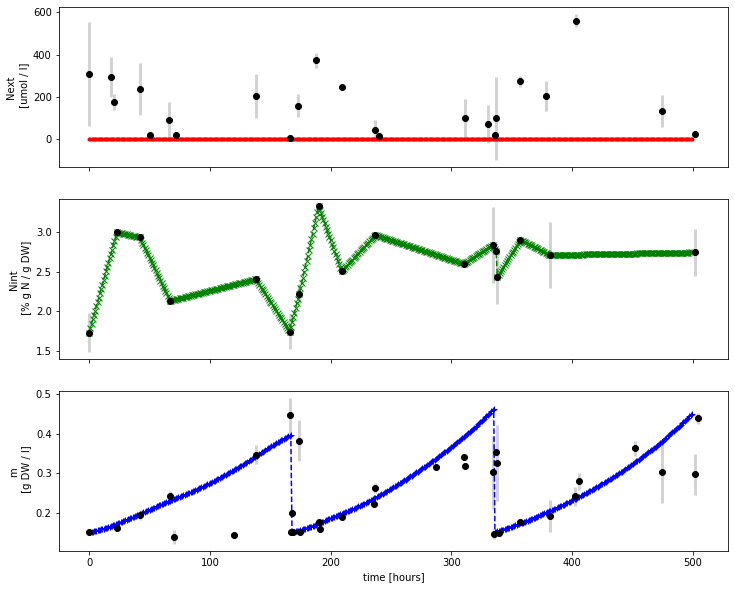

In [24]:
plot_result(t_hours,Next_model,Nint_model,m_model,Nint=Nint_mean_values, yerrNint=Nint_stdev_values ,tNint=Nint_times_reduced,m=m_mean_values, yerrm=m_stdev_values, tm=m_times_reduced,Next=Next_mean_values,yerrNext=Next_stdev_values, tNext=Next_times_reduced)

In [25]:
# TRE = (100/n) * sqrt (sigma[1:m]((PVi-Si)/Si)^2)

# where n is the number of measurements, Si is the measured values,and PVi is the predicted value

#TRE m

Sim, PVim, squere_error_m, trem = [], [], [], []
nmt = len(m_times_all)
nm = len(m_all)

m_times_all_tup = np.array(m_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

m_all_ind = np.linspace(0,nmt - 1,nmt)
m_all_ind = np.array(m_all_ind, dtype='int')

for i in m_all_ind:
    if i < 1 or m_times_all_tup[i] != m_times_all_tup[i-1]:
        j = m_times_all_tup[i]
        while j >= len(m_model):
            m_model.append(m_model[-1])
            #print(len(m_model))
    PVim.append(m_model[j])
    Sim.append(m_all[i])
    squere_error_m = ((PVim[-1] - Sim[-1]) / Sim[-1]) ** 2
    #if squere_error_m.size > 0:
    #trem.append(squere_error_m)
    trem.append(((PVim[-1] - Sim[-1]) / Sim[-1]) ** 2)
    #print(j,i)
    #print(PVim[-1])
    #print(Sim[-1])
    #print(squere_error_m, '\n')

TREm = round((100/nm * (sum(trem) ** 0.5)),1)

#TRE Nint

SiNint, PViNint, squere_error_Nint, treNint = [], [], [], []

nNintt = len(Nint_times_all)
nNint = len(Nint_all)

Nint_times_all_tup = np.array(Nint_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

Nint_all_ind = np.linspace(0,nNintt - 1,nNintt)
Nint_all_ind = np.array(Nint_all_ind, dtype='int')

for i in Nint_all_ind:
    if i < 1 or Nint_times_all_tup[i] != Nint_times_all_tup[i-1]:
        j = Nint_times_all_tup[i]
        while j >= len(Nint_model):
            #Nint_model.append(Nint_model[-1])
            Nint_model = np.append(Nint_model,Nint_model[-1])
            #print(len(Nint_model))
    PViNint.append(Nint_model[j])
    SiNint.append(Nint_all[i])
    squere_error_Nint = ((PViNint[-1] - SiNint[-1]) / SiNint[-1]) ** 2
    #if squere_error_Nint.size > 0:
    treNint.append(((PViNint[-1] - SiNint[-1]) / SiNint[-1]) ** 2)
    #print(j,i)
    #print(PVim[-1])
    #print(Sim[-1])
    #print(squere_error_m, '\n')

TRENint = round((100/nNint * (sum(treNint) ** 0.5)),1)

#TRE Next

SiNext, PViNext, squere_error_Next, treNext = [], [], [], []

nNextt = len(Next_times_all)
nNext = len(Next_all)

Next_times_all_tup = np.array(Next_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

Next_all_ind = np.linspace(0,nNextt - 1,nNextt)
Next_all_ind = np.array(Next_all_ind, dtype='int')

for i in Next_all_ind:
    if i < 1 or Next_times_all_tup[i] != Next_times_all_tup[i-1]:
        j = Next_times_all_tup[i]
        while j >= len(Next_model):
            Next_model.append(Next_model[-1])
            #print(len(Next_model))
    PViNext.append(Next_model[j])
    SiNext.append(Next_all[i])
    squere_error_Next = ((PViNext[-1] - SiNext[-1]) / SiNext[-1]) ** 2
    #if squere_error_Next.size > 0:
    treNext.append(((PViNext[-1] - SiNext[-1]) / SiNext[-1]) ** 2)
    #print(j,i)
    #print(PViNext[-1])
    #print(SiNext[-1])
    #print(squere_error_Next, '\n')


TRENext = round((100/nNext * (sum(treNext) ** 0.5)),1)
#print(treNext)
print("Model TRE (based on measured Nint and constant 0 Next): \n ")
print("mass TRE: " + str(TREm))
print("Nint TRE: " + str(TRENint))
print("Next TRE: " + str(TRENext))

Model TRE (based on measured Nint and constant 0 Next): 
 
mass TRE: 5.6
Nint TRE: 1.4
Next TRE: 10.8


# Model dNextdt based on measured Nint and m

In [26]:
# Model dNextdt based on measured Nint and m.

NEXT = []
m_model = m_interp
Nint_model = Nint_interp
A = [1, 2, 3]
t = 0
for i in A:
    Next = Amplitude
    while t < Duration * 24 * i and t < 500:
        m = m_interp[t]
        Nint = Nint_interp[t]
        Neff = (Nintmax - Nint)/(Nintmax - Nintmin) # units: [-]
        uN = Vmax * Next / (Ks + Next) # units: [umol N/g DW/h]
        #fN = ((Nint - Nintmin)/Nint) / ((Nintmax - Nintmin)/Nintmax) # units: [-]
        NEXT.append(Next)
        dNext = -Neff * uN * m - dNextoutdt + dNextindt # units: [umol N/l/h]
        Next = NEXT[t] + dNext
        if t > 0 and np.mod(t,Period*24) == 0 and np.mod(t,Duration*24) != 0:
            # period passed, not Duration
            # add amplitude, keep going 
            Next = NEXT[-1] + Amplitude
        t = t + 1
Next_model = NEXT

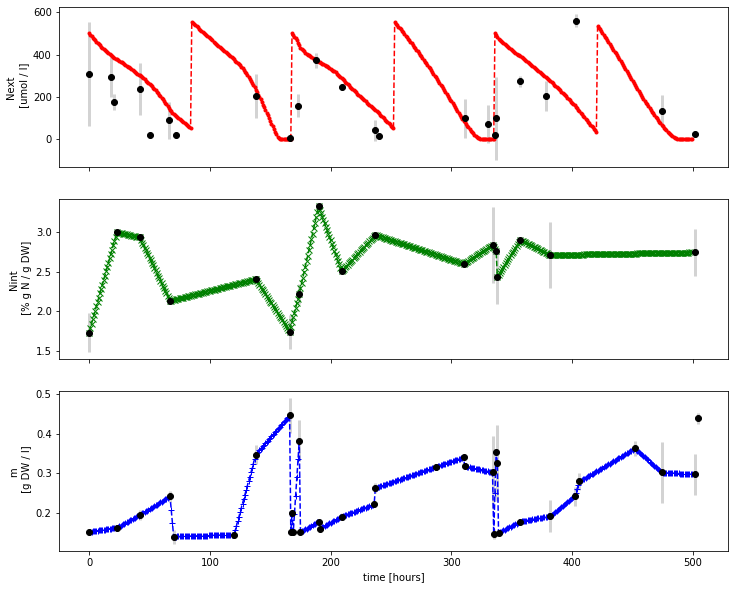

In [27]:
plot_result(t_hours,Next_model,Nint_model,m_model,Nint=Nint_mean_values, yerrNint=Nint_stdev_values ,tNint=Nint_times_reduced,m=m_mean_values, yerrm=m_stdev_values, tm=m_times_reduced,Next=Next_mean_values,yerrNext=Next_stdev_values, tNext=Next_times_reduced)

In [28]:
# TRE = (100/n) * sqrt (sigma[1:m]((PVi-Si)/Si)^2)

# where n is the number of measurements, Si is the measured values,and PVi is the predicted value

#TRE m

Sim, PVim, squere_error_m, trem = [], [], [], []
nmt = len(m_times_all)
nm = len(m_all)

m_times_all_tup = np.array(m_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

m_all_ind = np.linspace(0,nmt - 1,nmt)
m_all_ind = np.array(m_all_ind, dtype='int')

for i in m_all_ind:
    if i < 1 or m_times_all_tup[i] != m_times_all_tup[i-1]:
        j = m_times_all_tup[i]
        while j >= len(m_model):
            #m_model.append(m_model[-1])
            m_model = np.append(m_model,m_model[-1])
            #print(len(m_model))
    PVim.append(m_model[j])
    Sim.append(m_all[i])
    squere_error_m = ((PVim[-1] - Sim[-1]) / Sim[-1]) ** 2
    #if squere_error_m.size > 0:
    #trem.append(squere_error_m)
    trem.append(((PVim[-1] - Sim[-1]) / Sim[-1]) ** 2)
    #print(j,i)
    #print(PVim[-1])
    #print(Sim[-1])
    #print(squere_error_m, '\n')

TREm = round((100/nm * (sum(trem) ** 0.5)),1)

#TRE Nint

SiNint, PViNint, squere_error_Nint, treNint = [], [], [], []

nNintt = len(Nint_times_all)
nNint = len(Nint_all)

Nint_times_all_tup = np.array(Nint_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

Nint_all_ind = np.linspace(0,nNintt - 1,nNintt)
Nint_all_ind = np.array(Nint_all_ind, dtype='int')

for i in Nint_all_ind:
    if i < 1 or Nint_times_all_tup[i] != Nint_times_all_tup[i-1]:
        j = Nint_times_all_tup[i]
        while j >= len(Nint_model):
            #Nint_model.append(Nint_model[-1])
            Nint_model = np.append(Nint_model,Nint_model[-1])
            #print(len(Nint_model))
    PViNint.append(Nint_model[j])
    SiNint.append(Nint_all[i])
    squere_error_Nint = ((PViNint[-1] - SiNint[-1]) / SiNint[-1]) ** 2
    #if squere_error_Nint.size > 0:
    treNint.append(((PViNint[-1] - SiNint[-1]) / SiNint[-1]) ** 2)
    #print(j,i)
    #print(PVim[-1])
    #print(Sim[-1])
    #print(squere_error_m, '\n')

TRENint = round((100/nNint * (sum(treNint) ** 0.5)),1)

#TRE Next

SiNext, PViNext, squere_error_Next, treNext = [], [], [], []

nNextt = len(Next_times_all)
nNext = len(Next_all)

Next_times_all_tup = np.array(Next_times_all)
t_model_tup = np.array(t_model)

#print(nmt)
#print(nm)
# add a test - 

Next_all_ind = np.linspace(0,nNextt - 1,nNextt)
Next_all_ind = np.array(Next_all_ind, dtype='int')

for i in Next_all_ind:
    if i < 1 or Next_times_all_tup[i] != Next_times_all_tup[i-1]:
        j = Next_times_all_tup[i]
        while j >= len(Next_model):
            Next_model.append(Next_model[-1])
            #print(len(Next_model))
    PViNext.append(Next_model[j])
    SiNext.append(Next_all[i])
    squere_error_Next = ((PViNext[-1] - SiNext[-1]) / SiNext[-1]) ** 2
    #if squere_error_Next.size > 0:
    treNext.append(((PViNext[-1] - SiNext[-1]) / SiNext[-1]) ** 2)
    #print(j,i)
    #print(PViNext[-1])
    #print(SiNext[-1])
    #print(squere_error_Next, '\n')


TRENext = round((100/nNext * (sum(treNext) ** 0.5)),1)
#print(treNext)
print("Model TRE (based on measured Nint and m): \n ")
print("mass TRE: " + str(TREm))
print("Nint TRE: " + str(TRENint))
print("Next TRE: " + str(TRENext))

Model TRE (based on measured Nint and m): 
 
mass TRE: 1.5
Nint TRE: 1.4
Next TRE: 139.2


In [31]:
Next_leftover, Next_decrease, NEXT_decrease_g, m_accumulated, m_added, ADDED_N_gap_per = [],[],[],[], [], []

print("Leftover external N [umol/l]:         Decrease in external N [umol/l]:         Decrease in external N [g N/l]:\n\n")
for i in range(len(Period_times)):
    print(i)
    if i + 2 == len(Period_times):
        min_Next = round(min(Next_interp[range(Period_times[i],len(Next_interp))]),2) 
        Next_leftover.append(min_Next)
        Next_decrease.append(round(Amplitude - min_Next,2))
        Next_decrease_g = 14e-6 * (Amplitude - min_Next)
        NEXT_decrease_g.append(round(Next_decrease_g,4))
        print("Period " + str(i+1) + ":   " + str(int(min_Next)) + "                          " + str(Next_decrease[i])+ "                               " + str(NEXT_decrease_g[i]))
        break
    else:
        min_Next = round(min(Next_interp[range(Period_times[i],Period_times[i+1])]),2)
        Next_leftover.append(min_Next)
        Next_decrease.append(round(Amplitude - min_Next,2))
        Next_decrease_g = 14e-6 * (Amplitude - min_Next)
        NEXT_decrease_g.append(round(Next_decrease_g,4))
        print("Period " + str(i+1) + ":   " + str(int(min_Next)) + "                          " + str(Next_decrease[i])+ "                               " + str(NEXT_decrease_g[i]))

print("\nAccumulated m [g FW/l]:          Added m [g DW/l]:    Internal N [% g N/g DW]:    Added N [g N / l]:  Added N gap [g N /l]: \n\n")
for i in range(len(Duration_times)):
    if i + 2 == len(Duration_times):
        m_max = round(max(m_interp[range(Duration_times[i],len(m_interp))]),2)
        index_m_max = Duration_times[i] + np.argmax(m_interp[range(Duration_times[i],len(m_interp))])
        Nint_m_max = round(Nint_interp[index_m_max],2)
        Added_N = round(0.01 * Nint_m_max * m_max,4)
        Added_N_gap = round(NEXT_decrease_g[int(Duration/Period)*i+1] + NEXT_decrease_g[int(Duration/Period)*i]- Added_N,4)
        Added_N_gap_per = Added_N / (NEXT_decrease_g[int(Duration/Period)*i+1] + NEXT_decrease_g[int(Duration/Period)*i])
        ADDED_N_gap_per.append(round(Added_N_gap_per,2))
        m_accumulated.append(round(m_max,2))
        m_added.append(round(m_max - m0,2))
        print("Week " + str(i+1) + ":   " + str(round(m_max,2)) + "                          " + str(m_added[i]) + "                  " + str(Nint_m_max) + "                         " + str(Added_N) + "              " + str(Added_N_gap))
        break
    else:
        m_max = round(max(m_interp[range(Duration_times[i],Duration_times[i+1])]),2)
        index_m_max = Duration_times[i] + np.argmax(m_interp[range(Duration_times[i],len(m_interp))])
        Nint_m_max = round(Nint_interp[index_m_max],2)
        Added_N = round(0.01 * Nint_m_max * m_max,4)
        Added_N_gap = round(NEXT_decrease_g[int(Duration/Period)*i+1] + NEXT_decrease_g[int(Duration/Period)*i]- Added_N,4) #need to generalize
        Added_N_gap_per = Added_N / (NEXT_decrease_g[int(Duration/Period)*i+1] + NEXT_decrease_g[int(Duration/Period)*i])
        ADDED_N_gap_per.append(round(Added_N_gap_per,2))
        m_accumulated.append(round(m_max,2))
        m_added.append(round(m_max - round(m0,2),2))
        print("Week " + str(i+1) + ":   " + str(m_max) + "                          " + str(m_added[i])  + "                  " + str(Nint_m_max) + "                         " + str(Added_N) + "              " + str(Added_N_gap))
        
    
print("\npercent of N which entered biomass in each week is:" + str(ADDED_N_gap_per))

Leftover external N [umol/l]:         Decrease in external N [umol/l]:         Decrease in external N [g N/l]:


0
Period 1:   17                          482.17                               0.0068
1
Period 2:   6                          493.18                               0.0069
2
Period 3:   16                          483.08                               0.0068
3
Period 4:   29                          470.66                               0.0066
4
Period 5:   20                          479.46                               0.0067
5
Period 6:   37                          462.79                               0.0065

Accumulated m [g FW/l]:          Added m [g DW/l]:    Internal N [% g N/g DW]:    Added N [g N / l]:  Added N gap [g N /l]: 


Week 1:   0.45                          0.3                  1.74                         0.0078              0.0059
Week 2:   0.38                          0.23                  2.22                         0.0084              0.005
Week 3:   